<a href="https://colab.research.google.com/github/MuhammadSafeer786/My-PyTorch-Journey/blob/main/Chapter_02_PyTorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Data

In [78]:
import torch
from torch import nn # all building blockes for neural network
import matplotlib.pyplot as plt
torch.__version__

'2.5.1+cu121'

Trying to create our own dataset by **Linear Regression** Formula

In [79]:
# create known parameters
weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [80]:
train_split = int(0.8 * len(X)) # no. of samples for training
train_split

40

In [81]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [82]:
def plot_predictions(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
  plt.figure(figsize=(10, 7))

  # plot training data in green
  plt.scatter(train_data, train_labels, c="g", s=4, label="Training data")

  # plot test data in red
  plt.scatter(test_data, test_labels, c="b", s=20, label="Testing data")

  if predictions is not None:
    # plot predictions in blue
    plt.scatter(test_data, predictions, c="r", s=20, label="Predictions")

  # show legend
  plt.legend(prop={"size": 20})

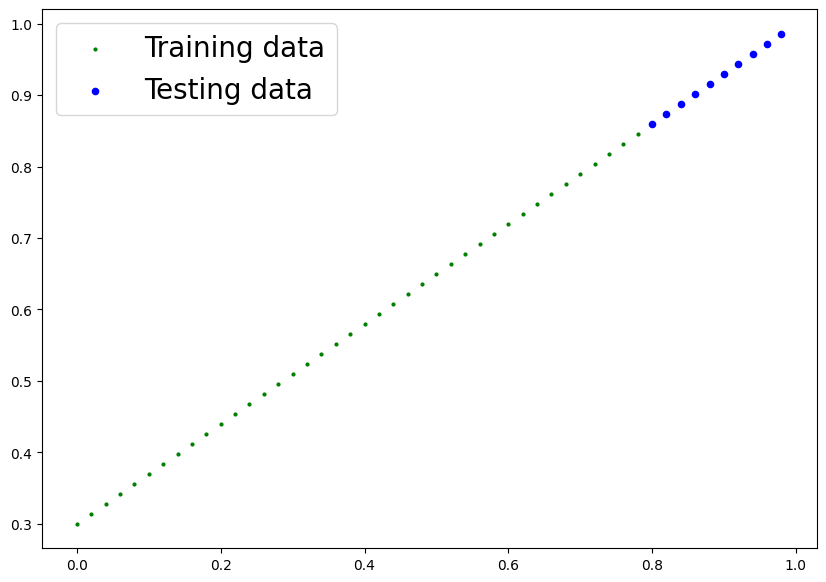

In [83]:
plot_predictions()

# Building Model
Must watch these (for me only):

Gradient descent - https://youtu.be/IHZwWFHWa-w

Backpropagation - https://youtu.be/Ilg3gGewQ5U

**Search about super().__init__()**

In [84]:
class CustomLinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # forward pass method in linear regression method
  def forward(self, x: torch.Tensor) -> torch.Tensor: # type hint / annotation, means dtype of x should be torch.Tensor and -> means return type should be as specified after this symbol
    return self.weights * x + self.bias

## PyTorch cheat sheet
https://pytorch.org/tutorials/beginner/ptcheat.html

# Check Model contents

In [85]:
torch.manual_seed(42)
model = CustomLinearRegression()

list(model.parameters()) # model.parameters() is a generator so i converted it to list for visualizing

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [86]:
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

# Making Predictions without Training
Turning of gradient tracking and only forward pass

For reading differences between torch.no_grad() and torch.inference_mode() search these on twitter.

In [87]:
with torch.inference_mode(): # torch.no_grad() can also be used. these mode just disable gradient tracking, for testing, faster calculation
  y_preds = model(X_test) # can only use this code for getting predictions but would also track gradient.

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

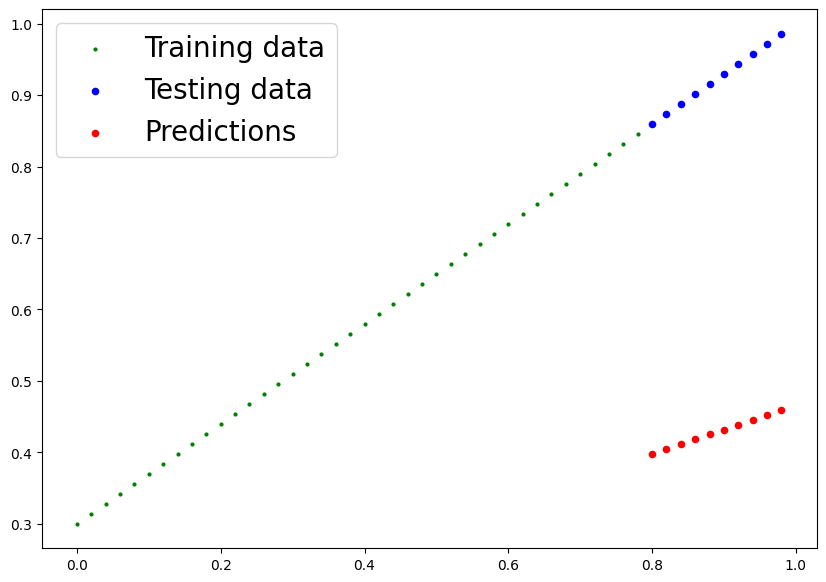

In [88]:
plot_predictions(predictions=y_preds)

# Training Model

* Loss Function i.e. mean squared error
* Optimizer i.e. gradient descent

In [89]:
loss_func = nn.L1Loss() # mean squared error
optimizer = torch.optim.SGD(params = model.parameters(), lr=0.01) # stochastic gradient descent

In [90]:
from IPython.display import clear_output

def plot_predictions_dynamic(train_data, train_labels, predictions=None):

    clear_output(wait=True)  # Clear previous output
    plt.figure(figsize=(10, 7))

    # Plot training data in green
    plt.scatter(train_data, train_labels, c="g", s=4, label="Training data")

    if predictions is not None:
        # Plot predictions in red
        plt.plot(train_data, predictions, c="r", label="Predictions")

    # Show legend
    plt.legend(prop={"size": 10})
    plt.show()


**Why turn off grads after every iteration in the following loop?**

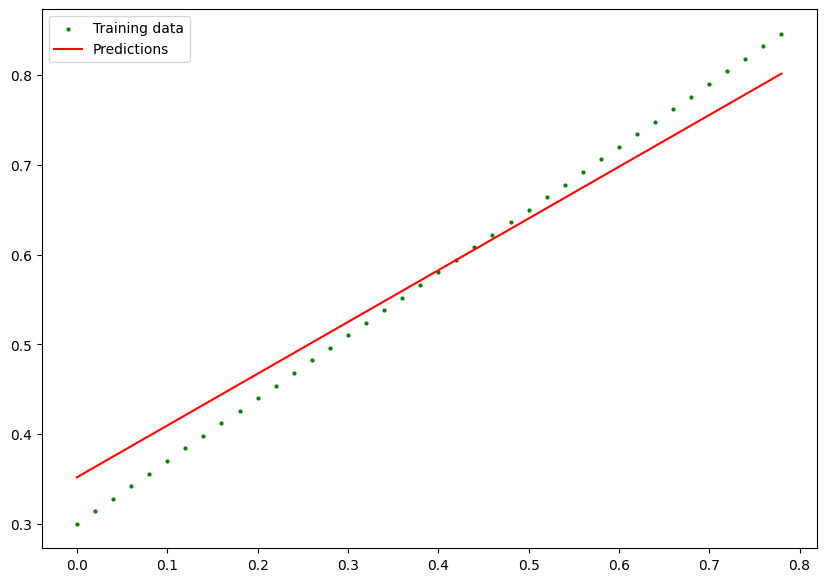

In [91]:
epochs = 100

for epoch in range(epochs):
    model.train()  # Enable training mode (enables gradient tracking)

    # Forward pass
    y_preds = model(X_train)

    # Plot predictions dynamically
    plot_predictions_dynamic(
        train_data=X_train.numpy(),
        train_labels=y_train.numpy(),
        predictions=y_preds.detach().numpy()
    )

    # Calculate loss
    loss = loss_func(y_preds, y_train)

    # Zero gradients
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Update parameters
    optimizer.step()

    model.eval() # optional



In [ ]:
y_preds.detach().numpy()

array([[0.13880941],
       [0.14562123],
       [0.15243302],
       [0.15924484],
       [0.16605663],
       [0.17286845],
       [0.17968026],
       [0.18649206],
       [0.19330387],
       [0.20011568],
       [0.20692748],
       [0.21373929],
       [0.2205511 ],
       [0.2273629 ],
       [0.23417471],
       [0.24098651],
       [0.24779832],
       [0.25461012],
       [0.26142192],
       [0.26823375],
       [0.27504557],
       [0.28185737],
       [0.28866917],
       [0.29548097],
       [0.30229276],
       [0.3091046 ],
       [0.3159164 ],
       [0.3227282 ],
       [0.32954   ],
       [0.3363518 ],
       [0.3431636 ],
       [0.34997544],
       [0.35678723],
       [0.36359903],
       [0.37041086],
       [0.37722266],
       [0.38403445],
       [0.39084628],
       [0.39765808],
       [0.40446988]], dtype=float32)

In [ ]:
# progress on youtube lecture soo far
# 6:46:47